In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
plt.rcParams['figure.constrained_layout.use'] = False
mpl.rcParams.update({'font.size': 9})

## Read in the data

Particle tracking data is stored at `Justice_League_Code/Data/tracked_particles.hdf5`. This HDF5 file format stores multiple tables efficiently and can be easily written to/read into `pandas`. Each galaxy that has been tracked is stored as a table in the HDF5 file under the key `{sim}_{z0haloid}`. For example:

In [3]:
path = '../../Data/tracked_particles.hdf5'
with pd.HDFStore(path) as hdf:
    print(hdf.keys())

['/h148_13', '/h148_28', '/h148_37', '/h148_68', '/h229_20', '/h229_22', '/h242_24', '/h242_80']


We'll use `h242_24` for now. 

In [4]:
key = 'h242_24'
data = pd.read_hdf(path, key=key)
data

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_Zc,host_vx,host_vy,host_vz,sat_disk,sat_halo,IGM,host_halo,host_disk,classification
0,5.181190,811077,0.000037,5.369499e+05,26510.536704,0.000000,317.229043,5.719189,-173.390813,23.552462,...,25968.551362,98.07,206.77,36.51,False,False,False,True,False,4.0
1,5.181190,6872943,0.000560,1.621470e+06,33820.435130,4.999814,305.111904,5.500734,-149.748558,152.158116,...,25968.551362,98.07,206.77,36.51,False,False,False,True,False,4.0
2,5.181190,8840402,0.000179,6.317682e+04,26510.536704,0.000000,352.882340,6.361967,133.276947,199.077824,...,25968.551362,98.07,206.77,36.51,False,False,True,False,False,5.0
3,5.181190,8987571,0.000017,2.664518e+05,26510.536704,0.000000,26.778647,0.482781,-9.585453,-3.929157,...,25968.551362,98.07,206.77,36.51,False,True,False,False,False,2.0
4,5.181190,9655109,0.000078,1.011527e+05,26510.536704,0.000000,16.040076,0.289180,-2.434631,-11.577726,...,25968.551362,98.07,206.77,36.51,False,True,False,False,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10476,13.800797,10503018,0.000018,2.953280e+05,26510.548793,0.000000,361.417481,7.212325,-312.938541,80.286533,...,26386.031648,107.68,154.11,21.47,False,False,False,True,False,4.0
10477,13.800797,10503024,0.000081,8.588152e+05,26520.522274,0.000000,240.255195,4.794451,-48.069470,61.066270,...,26386.031648,107.68,154.11,21.47,False,False,False,True,False,4.0
10478,13.800797,10503746,0.000117,1.134624e+06,26659.904046,5.228853,271.157246,5.411122,-121.951103,67.224175,...,26386.031648,107.68,154.11,21.47,False,False,False,True,False,4.0
10479,13.800797,10505840,0.000022,4.070112e+05,27619.316654,7.211029,267.735199,5.342833,14.907680,90.504259,...,26386.031648,107.68,154.11,21.47,False,False,False,True,False,4.0


In [188]:
data.head().T

,0,1,2,3,4
time,5.18119,5.18119,5.18119,5.18119,5.18119
pid,811077,6872943,8840402,8987571,9655109
rho,3.72866e-05,0.000559538,0.000179351,1.69046e-05,7.76563e-05
temp,536950,1.62147e+06,63176.8,266452,101153
mass,26510.5,33820.4,26510.5,26510.5,26510.5
coolontime,0,4.99981,0,0,0
r,317.229,305.112,352.882,26.7786,16.0401
r_per_Rvir,5.71919,5.50073,6.36197,0.482781,0.28918
x,-173.391,-149.749,133.277,-9.58545,-2.43463
y,23.5525,152.158,199.078,-3.92916,-11.5777


## Basic plots of satellite orbit and particle paths

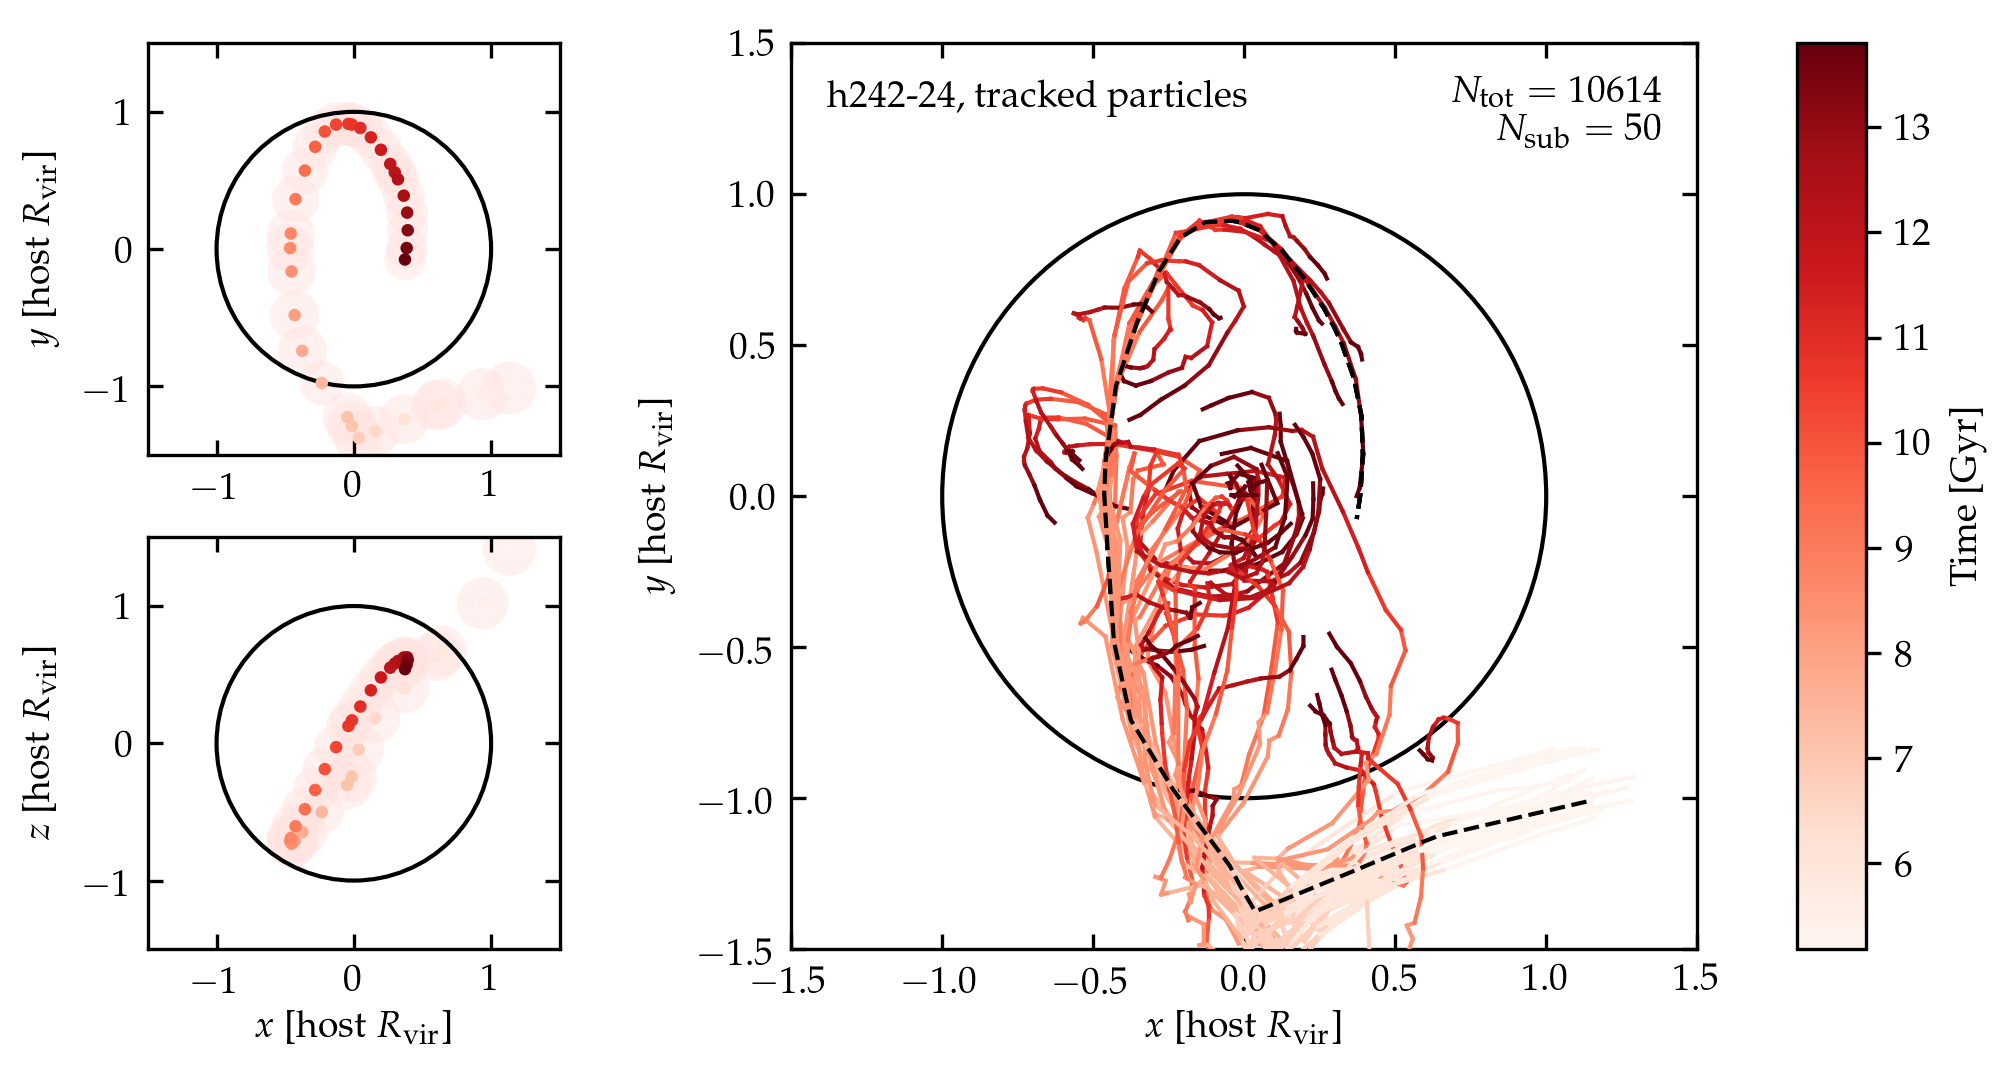

In [207]:
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value

R = 1.5
N = 50

# fig, ax = plt.subplots(1,3,figsize=(10,3),dpi=300)
fig = plt.figure(dpi=300, figsize=(7.5,4))
gs = mpl.gridspec.GridSpec(2,5, width_ratios = [1,0.1,1,1,0.15], figure=fig)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[0:,2:-1])
cbax = plt.subplot(gs[:,-1])

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax0.add_artist(host_radius)

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax1.add_artist(host_radius)

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax2.add_artist(host_radius)

x_rel, y_rel, z_rel, Rvirs, ts = np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
for t in np.unique(data.time):
    d = data[data.time==t]
    sat_x, sat_y, sat_z = np.mean(d.sat_Xc), np.mean(d.sat_Yc), np.mean(d.sat_Zc)
    host_x, host_y, host_z = np.mean(d.host_Xc), np.mean(d.host_Yc), np.mean(d.host_Zc)
    
    h1Rvir = np.mean(d.h1Rvir)
    satRvir = np.mean(d.satRvir)
    
    x_rel = np.append(x_rel, (sat_x-host_x)/h1Rvir)
    y_rel = np.append(y_rel, (sat_y-host_y)/h1Rvir)
    z_rel = np.append(z_rel, (sat_z-host_z)/h1Rvir)
    
    Rvirs = np.append(Rvirs, satRvir/h1Rvir*1100)
    
    radii = plt.Circle(((sat_x-host_x)/h1Rvir,(sat_y-host_y)/h1Rvir),
                     satRvir/h1Rvir, ec='none',fc='mistyrose', alpha=0.5, fill=True, zorder=0.5)
    ax0.add_artist(radii)
    
    radii = plt.Circle(((sat_x-host_x)/h1Rvir,(sat_z-host_z)/h1Rvir),
                     satRvir/h1Rvir, ec='none',fc='mistyrose', alpha=0.5, fill=True, zorder=0.5)
    ax1.add_artist(radii)
    
    ts = np.append(ts,t)
    
ax0.scatter(x_rel, y_rel, c=ts, cmap='Reds', s=4, zorder=2)
ax1.scatter(x_rel, z_rel, c=ts, cmap='Reds', s=4, zorder=2)
ax2.plot(x_rel, y_rel, 'k--', linewidth=1, zorder=1)
ax2.plot(x_rel, y_rel, 'k--', linewidth=1, zorder=1)
ax2.plot(x_rel, y_rel, 'k--', linewidth=1, zorder=1000)

pids = np.unique(data.pid)
np.random.seed(123)
pids_sub = np.random.choice(pids, size=N)

for j,pid in enumerate(pids_sub):
    d = data[data.pid==pid]
    
    cmap = mpl.cm.get_cmap('Reds', 12)
    tmin, tmax = np.min(d.time), np.max(d.time)
    
    
    ### hack for now, until I can go back into the code and scale xyz by a taken directly from the sim
    z = np.array([z_at_value(Planck15.age, (t-0.01)*u.Gyr) for t in d.time])
    a = 1/(1+z)
    
    ###
    
    i_prev = 0
    for i in range(len(d)-1):
        i += 1
        h1Rvir = list(d.h1Rvir)[i_prev]
        x1 = list(d.x_rel_host)[i_prev] / h1Rvir / a[i_prev]
        y1 = list(d.y_rel_host)[i_prev] / h1Rvir / a[i_prev]
        z1 = list(d.z_rel_host)[i_prev] / h1Rvir / a[i_prev]
        
        h1Rvir = list(d.h1Rvir)[i]
        x2 = list(d.x_rel_host)[i] / h1Rvir / a[i]
        y2 = list(d.y_rel_host)[i] / h1Rvir / a[i]
        z2 = list(d.z_rel_host)[i] / h1Rvir / a[i]
        t = list(d.time)[i]
        
        c = cmap((t-tmin)/(tmax-tmin))
                
        ax2.plot([x1,x2],[y1,y2],color=c, linewidth=1, zorder=j)
        
        #if j == 0:
        #    ax.arrow(0, 0, v_rel[0], v_rel[1], head_width=0.3, head_length=0.3, fc=c, ec=c, zorder=100+j)

        i_prev = i
    
    

cb1 = mpl.colorbar.ColorbarBase(cbax, cmap=mpl.cm.Reds, orientation='vertical', 
                                norm = mpl.colors.Normalize(vmin=tmin, vmax=tmax),
                                label='Time [Gyr]')

ax1.set_xlabel(r'$x$ [host $R_{\rm vir}$]')
ax1.set_ylabel(r'$z$ [host $R_{\rm vir}$]')
ax0.set_ylabel(r'$y$ [host $R_{\rm vir}$]')
# ax0.annotate(f"{key.replace('_','-')}, satellite orbit", (0.04, 0.96), xycoords='axes fraction', va='top')
ax2.annotate(f"{key.replace('_','-')}, tracked particles", (0.04, 0.96), xycoords='axes fraction', va='top')
ax2.annotate(r'$N_{\rm tot} =$' + fr' ${len(pids)}$'+'\n'+r'$N_{\rm sub} =$' + fr' ${N}$', 
            (0.96, 0.96), xycoords='axes fraction', va='top', ha='right')

ax0.set_xlim(-R,R)
ax0.set_ylim(-R,R)
ax1.set_xlim(-R,R)
ax1.set_ylim(-R,R)
ax2.set_xlim(-R,R)
ax2.set_ylim(-R,R)

ax0.set_aspect('equal')
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# ax2.set_xlabel(r'rotated coordinate $\tilde{x}$ [sat $R_{\rm vir}$]')
# ax2.set_ylabel(r'rotated coordinate $\tilde{y}$ [sat $R_{\rm vir}$]')
ax2.set_xlabel(r'$x$ [host $R_{\rm vir}$]')
ax2.set_ylabel(r'$y$ [host $R_{\rm vir}$]')


ax0.tick_params(top=True,right=True,direction='in', which='both')
ax1.tick_params(top=True,right=True,direction='in', which='both')
ax2.tick_params(top=True,right=True,direction='in', which='both')

plt.savefig(f'plots/{key}_orbit.pdf')

plt.show()

## messing around with coordinate transformation idea

In [6]:
pids = np.unique(data.pid)

np.random.seed(123)
pids_sub = np.random.choice(pids, size=50)

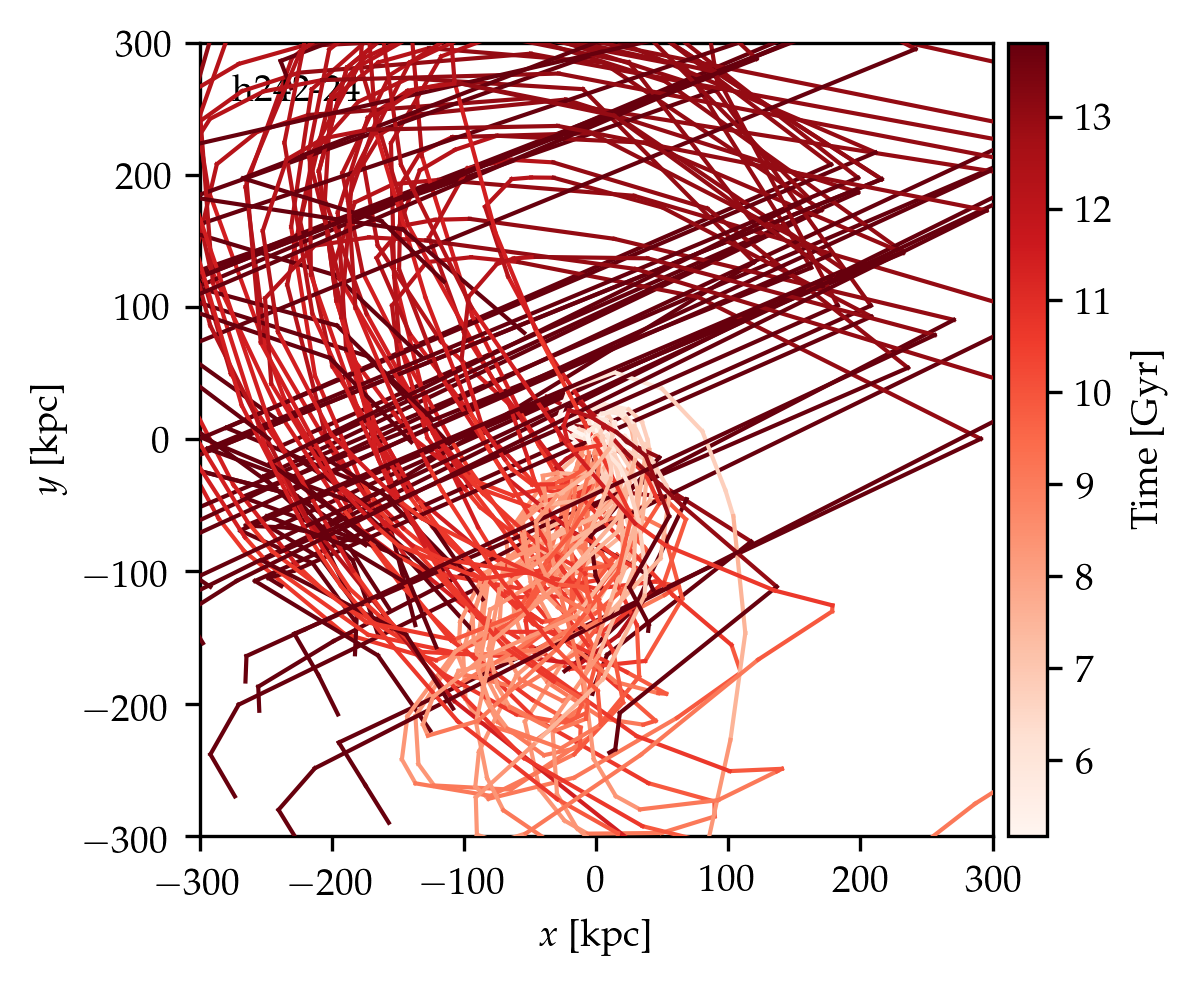

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
R = 300

fig, ax = plt.subplots(1,1,figsize=(4.2,3.5),dpi=300)
for j,pid in enumerate(pids_sub):
    d = data[data.pid==pid]
    
    cmap = mpl.cm.get_cmap('Reds', 12)
    tmin, tmax = np.min(d.time), np.max(d.time)
    
    i_prev = 0
    for i in range(len(d)-1):
        i += 1
        x1 = list(d.x)[i_prev]
        y1 = list(d.y)[i_prev]
        z1 = list(d.z)[i_prev]
        sat_v = np.array([list(d.sat_vx)[i_prev], list(d.sat_vy)[i_prev], list(d.sat_vz)[i_prev]])
        host_v = np.array([list(d.host_vx)[i_prev], list(d.host_vy)[i_prev], list(d.host_vz)[i_prev]])
        v1 = sat_v - host_v
        
        x2 = list(d.x)[i]
        y2 = list(d.y)[i]
        z2 = list(d.z)[i]
        sat_v = np.array([list(d.sat_vx)[i], list(d.sat_vy)[i], list(d.sat_vz)[i]])
        host_v = np.array([list(d.host_vx)[i], list(d.host_vy)[i], list(d.host_vz)[i]])
        v2 = sat_v - host_v
        t = list(d.time)[i]

        sat_p1 = np.array([list(d.sat_Xc)[i_prev], list(d.sat_Yc)[i_prev], list(d.sat_Zc)[i_prev]])
        host_p1 = np.array([list(d.host_Xc)[i_prev], list(d.host_Yc)[i_prev], list(d.host_Zc)[i_prev]])
        p1 = sat_p1 - host_p1
        
        sat_p2 = np.array([list(d.sat_Xc)[i], list(d.sat_Yc)[i], list(d.sat_Zc)[i]])
        host_p2 = np.array([list(d.host_Xc)[i], list(d.host_Yc)[i], list(d.host_Zc)[i]])
        p2 = sat_p2 - host_p2
        
        ### transformation code.... still not working quite right
        r1 = np.array([x1,y1,z1])
        r2 = np.array([x2,y2,z2])
        yhat = np.array([0,1,0])
        
        matr = rotation_matrix_from_vectors(yhat,v1)
        r1 = matr @ r1
        x1,y1,z1 = r1[0],r1[1],r1[2]
        
        matr = rotation_matrix_from_vectors(yhat,v2)
        r2 = matr @ r2
        x2,y2,z2 = r2[0],r2[1],r2[2]
        
        
        xhat = np.array([1,0,0])
        matr = rotation_matrix_from_vectors(xhat,p1)
        r1 = matr @ r1
        x1,y1,z1 = r1[0],r1[1],r1[2]

        matr = rotation_matrix_from_vectors(xhat,p2)
        r2 = matr @ r2
        x2,y2,z2 = r2[0],r2[1],r2[2]
        ###
        
        c = cmap((t-tmin)/(tmax-tmin))
                
        ax.plot([x1,x2],[y1,y2],color=c, linewidth=1, zorder=j)
        
#         if j == 0:
#             ax.arrow(0, 0, v_rel[0], v_rel[1], head_width=0.3, head_length=0.3, fc=c, ec=c, zorder=100+j)

        i_prev = i
    
    
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.Reds, orientation='vertical', 
                                norm = mpl.colors.Normalize(vmin=tmin, vmax=tmax),
                                label='Time [Gyr]')
fig.add_axes(ax_cb)

    
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_xlabel(r'$x$ [kpc]')
ax.set_ylabel(r'$y$ [kpc]')
ax.annotate(key.replace("_","-"), (0.04,0.96), xycoords='axes fraction', va='top')
ax.set_aspect('equal')


plt.show()

## Test code to transform coordinate system

In [33]:
v = np.array([12,-15,5])
r = np.array([0,0,1])*np.linalg.norm(v)

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

matr = rotation_matrix_from_vectors(r,v)
out = matr @ np.array([1,0,0])

-12.0

## identifying gas particles that have just left the satellite halo

In [161]:
import tqdm
times = np.unique(data.time)

d_prev = data[data.time==times[0]]
# fix for now
prev_sat_disk = (d_prev.rho >= 0.1) & (d_prev.temp <= 1.2e4) & (d_prev.r <= 3)
prev_sat_halo = (d_prev.r_per_Rvir < 1) & ~prev_sat_disk

pids = np.unique(data.pid)
just_left = pd.DataFrame()
for pid in tqdm.tqdm(pids):
    dat = data[data.pid==pid]
    
    sat_disk = np.array((dat.rho >= 0.1) & (dat.temp <= 1.2e4) & (dat.r <= 3),dtype=bool)
    sat_halo = np.array((dat.r_per_Rvir < 1),dtype=bool) & ~sat_disk
    host_halo = np.array(dat.host_halo, dtype=bool)
    
    
    i = 0
    for t in dat.time:
        if i != 0:
            if sat_halo[i-1] and host_halo[i]:
                just_left = pd.concat([just_left,dat[dat.time==t]])
        
        i += 1

just_left

100%|██████████| 10614/10614 [00:47<00:00, 222.13it/s]


,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_Zc,host_vx,host_vy,host_vz,sat_disk,sat_halo,IGM,host_halo,host_disk,classification
0,10.352954,811077,0.000017,1.086080e+05,26510.543612,0.000000,57.487461,1.113112,-28.567391,-28.930443,...,26298.455502,107.09,179.88,28.91,False,False,False,True,False,4.0
1,9.706484,6872943,0.000063,2.498220e+04,33820.794348,4.999814,88.077183,1.683288,-49.520885,-45.805472,...,26273.698264,106.62,184.51,30.96,False,False,False,True,False,4.0
2,12.938837,8840402,0.000007,7.381693e+05,26262.456941,0.000000,64.293344,1.276252,-21.064121,60.718051,...,26366.003319,108.12,160.49,22.87,False,False,False,True,False,4.0
3,9.060013,8987571,0.000029,3.033766e+05,26510.536704,0.000000,76.806575,1.444267,35.561975,-67.273058,...,26240.281811,104.91,187.70,33.21,False,False,False,True,False,4.0
4,8.090307,9655109,0.000047,5.245932e+04,26510.536704,0.000000,69.771686,1.276218,18.291943,-67.237763,...,26185.166890,100.74,195.17,38.55,False,False,False,True,False,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10606,8.608831,10503018,0.000043,5.882960e+04,26510.536704,0.000000,66.364067,1.232179,14.630876,-62.546152,...,26216.386314,103.52,191.41,35.84,False,False,False,True,False,4.0
10607,8.736778,10503024,0.000037,1.475302e+05,26519.952361,0.000000,61.254605,1.141691,18.798251,-56.445181,...,26223.292507,103.95,190.36,34.85,False,False,False,True,False,4.0
10608,7.767072,10503746,0.000057,1.141102e+05,26657.753919,5.228853,81.288456,1.478098,25.040005,-77.326077,...,26168.397499,100.33,197.70,39.68,False,False,False,True,False,4.0
10609,8.413543,10505840,0.000020,1.170686e+06,27615.513779,7.211029,71.621509,1.321827,18.740840,-67.650754,...,26205.723216,102.78,192.77,37.96,False,False,False,True,False,4.0


Compute angle between the particle velocity vectors (measured relative to the satellite) and the bulk host velocity (measured relative to the satellite). The latter acts as a proxy for the CGM wind velocity, which we could compute later if we want to. 

If the exit angle (angle between these vectors) is generally around 0, then we know that the particles are generally moving the same direction as the CGM relative to the satellite, a clear signature of ram pressure stripping. If the angle is more uniformly distributed, the particles are leaving in every direction, a more clear signature of feedback or tidal stripping. 

In [208]:
just_left.keys()

Index(['time', 'pid', 'rho', 'temp', 'mass', 'coolontime', 'r', 'r_per_Rvir',
       'x', 'y', 'z', 'satRvir', 'vx', 'vy', 'vz', 'v', 'x_rel_host',
       'y_rel_host', 'z_rel_host', 'h1dist', 'h1Rvir', 'sat_Xc', 'sat_Yc',
       'sat_Zc', 'sat_vx', 'sat_vy', 'sat_vz', 'host_Xc', 'host_Yc', 'host_Zc',
       'host_vx', 'host_vy', 'host_vz', 'sat_disk', 'sat_halo', 'IGM',
       'host_halo', 'host_disk', 'classification'],
      dtype='object')

In [213]:
angles = np.array([])

for d in tqdm.tqdm(just_left.iterrows()):
    v = np.array([d[1].vx,d[1].vy,d[1].vz])
    v_sat = np.array([d[1].sat_vx,d[1].sat_vy,d[1].sat_vz])
    v_host = np.array([d[1].host_vx,d[1].host_vy,d[1].host_vz])
    v_rel = v_host - v_sat # different than usual
    
    v_hat = v / np.linalg.norm(v)
    v_rel_hat = v_rel / np.linalg.norm(v_rel)
    angle = np.arccos(np.dot(v_hat,v_rel_hat)) * 180/np.pi
    angles = np.append(angles,angle)

10482it [00:02, 4346.68it/s]


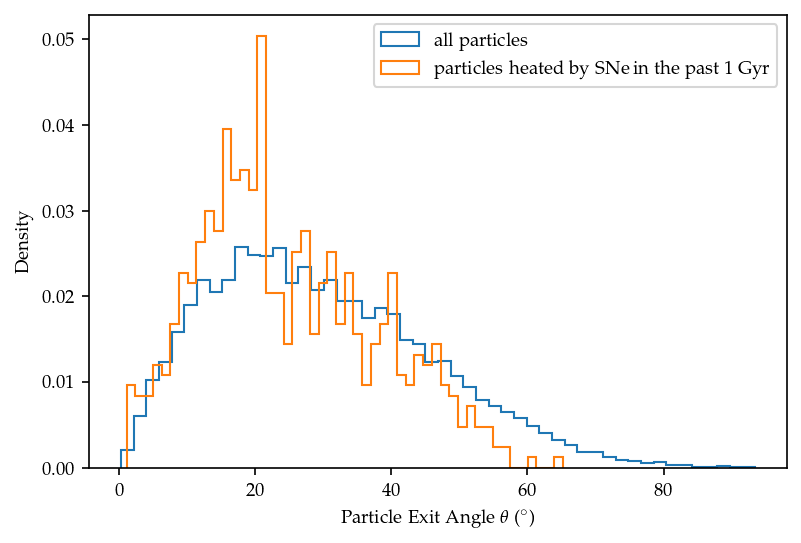

In [215]:
plt.figure(dpi=150)
plt.hist(angles, histtype='step', bins=50, density=True, label='all particles')

SNe_bool = np.array(just_left.coolontime > just_left.time - 1,dtype=bool)
plt.hist(angles[SNe_bool], histtype='step', bins=50, density=True, label='particles heated by SNe in the past 1 Gyr')

plt.xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
plt.ylabel('Density')
plt.legend()
plt.show()

[ 5.18118989  8.05439242 10.92759496 13.8007975 ]


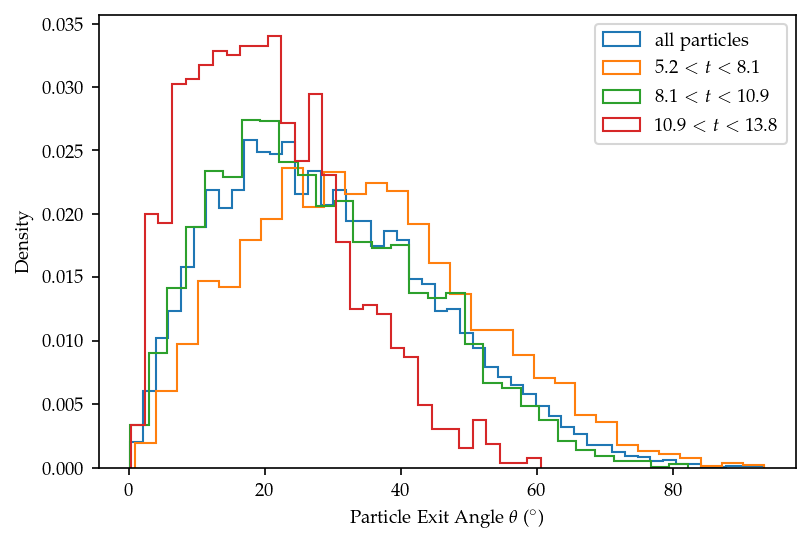

In [216]:
plt.figure(dpi=150)
plt.hist(angles, histtype='step', bins=50, density=True, label='all particles')

tbins = np.linspace(tmin,tmax,4)
print(tbins)
for t1,t2 in zip(tbins[:-1],tbins[1:]):
    plt.hist(angles[(just_left.time > t1)&(just_left.time < t2)], histtype='step', bins=30, density=True, label=fr'${t1:.1f} < t < {t2:.1f}$')

plt.xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
plt.ylabel('Density')
plt.legend()
plt.show()

[0.66066025 0.89924687 1.13783348 1.37642009]


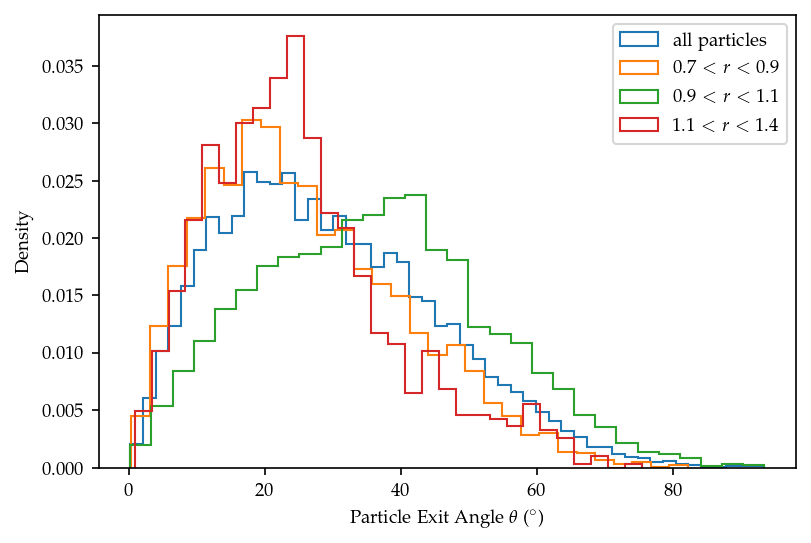

In [217]:
plt.figure(dpi=150)
plt.hist(angles, histtype='step', bins=50, density=True, label='all particles')

sat_h1dist = np.array([just_left.sat_Xc,just_left.sat_Yc,just_left.sat_Zc],dtype=float) - np.array([just_left.host_Xc,just_left.host_Yc,just_left.host_Zc],dtype=float)
sat_h1dist /= np.array(just_left.h1Rvir,dtype=float)
sat_h1dist = sat_h1dist.T
sat_h1dist = np.array([np.sqrt(np.sum(d**2)) for d in sat_h1dist])

rbins = np.linspace(np.min(sat_h1dist),np.max(sat_h1dist),4)
print(rbins)
for r1,r2 in zip(rbins[:-1],rbins[1:]):
    plt.hist(angles[(sat_h1dist > r1)&(sat_h1dist < r2)], histtype='step', bins=30, density=True, label=fr'${r1:.1f} < r < {r2:.1f}$')

plt.xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
plt.ylabel('Density')
plt.legend()
plt.show()

## compute mass-loss rates etc

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


[  5.19155947   2.83738499 109.71459181   6.60140954   0.31170355
   2.39533584   2.49464891  13.47611855   2.43484526   3.77513227
   2.790965     7.83116762  12.41395073   5.55392185   4.8199653
   5.20185115   4.68606463   5.70607125   5.26424933   4.1331415
  13.25815256   5.59770942  56.33278928   0.                  inf
          nan          nan          nan          nan          nan
          nan          nan]


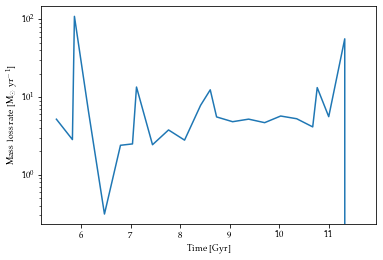

In [131]:
times = np.unique(data.time)

# start with: sat_halo to host_halo

# start with first snap tracked
d_prev = data[data.time==times[0]]
d_prev.sat_disk = (d_prev.rho >= 0.1) & (d_prev.temp <= 1.2e4) & (d_prev.r <= 3)
d_prev.sat_halo = (d_prev.r_per_Rvir < 1) & ~d_prev.sat_disk
t_prev = times[0]

mass_loss_rate = np.array([])
for t in times[1:]:
    d = data[data.time==t]

    d.sat_disk = (d.rho >= 0.1) & (d.temp <= 1.2e4) & (d.r <= 3)
    d.sat_halo = (d.r_per_Rvir < 1) & ~d.sat_disk
    
    # sorta hacky.... trying to make sure that we are accounting for loss of particles...
    d_prev = d_prev[np.isin(d_prev.pid, d.pid)]

    
    mass_lost = np.sum(d.mass[d_prev.sat_disk & d.sat_halo])/np.sum(d.mass[d_prev.sat_halo & d.sat_disk])
    mass_loss_rate = np.append(mass_loss_rate, mass_lost/(t-t_prev))
    

    #print(len(d.classification[np.array(d.classification)==np.array(d_prev.classification)])/len(d.classification))
    
    d_prev = d
    t_prev = t
    
print(mass_loss_rate)
plt.figure()
plt.plot(times[1:], mass_loss_rate)
plt.xlabel('Time [Gyr]')
plt.ylabel(r'Mass loss rate [M$_\odot$ yr$^{-1}$]')
plt.yscale('log')
plt.show()


In [78]:
mass_loss_rate

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])